# Root Cause Discovery + Lasso

Here for a known "root cause gene", lets run a Lasso regression to filter down the number of features, before running Root Cause Discovery algorithm

+ After processing, we obtained 2 datasets
    1. "Interventional data": there are 32 samples for which we have ground truth data. Each row is a gene and each column is a sample. 
    2. "observational data": these are a few hundred samples for which we did not do any intervention. Each row is a gene and each column is a sample.
+ The main idea is that an intervention supposedly caused a disturbance in gene expression, so we can compare the data of intervention to baseline (i.e. observational data), and try to which gene is most differentially expressed

In [1]:
using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

# import RootCauseDiscovery.zscore
# import RootCauseDiscovery.compute_permutations
# import RootCauseDiscovery.root_cause_discovery
# import RootCauseDiscovery.find_largest
# import RootCauseDiscovery.find_second_largest

# using Statistics
# import StatsBase.cov2cor
# using GLMNet
# using CovarianceEstimation
# using LinearAlgebra
# using Plots
# gr(fmt=:png)
# include("/home/users/bbchu/RootCauseDiscovery/utilities.jl")

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number; jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/joblogs/slurm-%j.out")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, total_mem::Number; jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/joblogs/slurm-%j.out")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

submit (generic function with 2 methods)

## Read processed data
First, read in data and log (base 2) transform them

In [2]:
# process raw data
# transform_int, transform_obs, ground_truth = QC_gene_expression_data();

# read processed data
dir = "/scratch/users/bbchu/RootCauseDiscovery/data"
transform_int = CSV.read(joinpath(dir, "transform_int"), DataFrame)
transform_obs = CSV.read(joinpath(dir, "transform_obs"), DataFrame)
ground_truth = CSV.read(joinpath(dir, "ground_truth"), DataFrame)

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

32×18786 transpose(::Matrix{Float64}) with eltype Float64:
 7.15963  7.52113  6.15452  5.75581  …  2.66477  1.72031   4.2403   5.86117
 7.27295  7.47476  5.71744  6.76805     3.86115  2.25171   3.82032  6.11873
 7.11711  7.69937  6.29269  5.83369     3.16361  1.24669   4.55723  6.01907
 7.32262  7.5701   5.62695  5.65956     3.26167  1.68122   4.18966  5.79909
 7.30718  7.64175  5.94946  5.70915     2.89075  2.19761   4.37236  6.22296
 7.955    7.62097  6.30596  5.60628  …  2.37088  0.579117  4.82761  5.77485
 6.8234   7.12233  5.8819   5.75597     3.24978  1.76171   4.57797  5.41422
 7.39594  6.96646  5.92392  5.21208     3.13891  2.3404    4.37728  5.50915
 6.96517  7.23575  5.89276  6.66992     2.43846  2.67962   4.1837   5.95136
 6.67546  7.15309  5.75577  6.28015     2.37818  2.0215    4.20273  5.73855
 7.23575  7.47955  5.86169  6.36955  …  2.88065  2.64703   4.1685   6.367
 7.23278  7.42347  6.16229  6.4314      1.67045  2.36359   4.39737  5.86872
 6.96603  7.20675  6.33847  4.9

## Test run Root Cause Discovery

In [3]:
# parameters for current run
patient_id = "R62943"
y_idx_z_threshold = 10.0
method = "largest_support"
outfile = "/scratch/users/bbchu/RootCauseDiscovery/result_3.18.2024/$(patient_id).jld2"

# run main alg
Random.seed!(2024)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=2
);

# save result in jld2 format
# save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

Trying 4 y_idx
Lasso found 362 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


Lasso found 361 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Lasso found 392 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


Lasso found 368 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


204.909245 seconds (18.00 M allocations: 82.330 GiB, 0.98% gc time, 9.11% compilation time)


In [4]:
results[1]

2240×7 Matrix{Float64}:
  284.795  284.709     0.0858234   0.000301442  349.0  1.99374   363.0
  443.647  443.41      0.236717    0.000533855   58.0  1.46261   363.0
  383.79   383.192     0.598697    0.00156239   202.0  1.36058   363.0
  487.543  486.77      0.7729      0.00158781   349.0  1.99374   363.0
  469.619  468.866     0.753489    0.00160705   160.0  1.1688    363.0
  220.94   220.517     0.423097    0.00191866    91.0  1.26185   363.0
  187.078  186.594     0.484328    0.00259563   228.0  1.32596   363.0
  471.243  469.944     1.29899     0.00276413   175.0  0.554986  363.0
  573.482  571.369     2.11272     0.00369764   349.0  1.99374   363.0
  290.047  288.876     1.17138     0.00405495   336.0  3.30845   363.0
  268.782  267.624     1.15848     0.00432875   188.0  2.26229   363.0
  541.459  539.012     2.44756     0.00454082   230.0  2.41454   363.0
  388.033  386.227     1.80692     0.00467838    58.0  1.46261   363.0
    ⋮                                                

In [5]:
y_indices

4-element Vector{Int64}:
  1030
 10956
 14722
 17579

## Test run Root Cause Discovery 

This assumes root cause is treated as response

In [16]:
# lasso 
Random.seed!(44568987654)
patient_id = "R80346" #  "R80346", "R58859", "R28774", "R62943", "R20754", "R36605", "R60537" works
root_cause_idx = ground_truth[
    findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
method = "largest_support"
Xobs_new, Xint_sample_new, root_cause_idx_new = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    root_cause_idx, Xobs, Xint, ground_truth, method)

# run main alg
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=10)
result

Lasso found 355 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


1151×7 Matrix{Float64}:
  947.923  947.852     0.0708989  7.47996e-5   335.0   0.0305478  356.0
  645.986  645.64      0.345128   0.000534551  356.0  38.3415     356.0
  947.923  947.098     0.824738   0.000870806  335.0   0.0305478  356.0
  948.822  947.923     0.899395   0.000948806  356.0  38.3415     356.0
  949.045  947.923     1.12169    0.00118331   356.0  38.3415     356.0
  947.923  946.589     1.33368    0.00140893   335.0   0.0305478  356.0
  947.923  946.103     1.81977    0.00192344   335.0   0.0305478  356.0
  947.923  946.059     1.86355    0.0019698    335.0   0.0305478  356.0
  950.039  947.923     2.11651    0.00223278   356.0  38.3415     356.0
  947.923  945.722     2.20102    0.00232735   335.0   0.0305478  356.0
  689.855  687.349     2.50542    0.00364504   356.0  38.3415     356.0
  951.44   947.923     3.51701    0.00371023   356.0  38.3415     356.0
  951.684  947.923     3.76143    0.00396808   356.0  38.3415     356.0
    ⋮                                   

## Submit jobs

In [ ]:
# put this in script /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/high_dimension_RCD.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using LinearAlgebra
BLAS.set_num_threads(1)

# inputs to the script
patient_id = ARGS[1]
y_idx_z_threshold = parse(Float64, ARGS[2])
method = ARGS[3] # "cv" or "largest_support"
outfile = ARGS[4]

# process raw data
transform_int, transform_obs, ground_truth = QC_gene_expression_data();

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

# run main alg
Random.seed!(2024)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=10
);

# save result
save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

# to load later, do:
# using JLD2
# results = load("R58859.jld2", "results")
# y_indices = load("R58859.jld2", "y_indices")


### Submit jobs for each patient

20 runs take ~300 sec, so if a patient requires 4000 tries, it'll take ~16.6h

In [13]:
dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024"

julia_exe = joinpath(dir, "high_dimension_RCD.jl")
y_idx_z_threshold = 1.5
patient_name = ground_truth[!, "Patient ID"]
for method in ["largest_support"]
    for patient in patient_name
        outfile = joinpath(dir, method, "$(patient).jld2")
        if !isfile(outfile)
            cmd = "julia -t 32 $julia_exe $patient $y_idx_z_threshold $method $outfile"
            submit(cmd, 32, 64, jobname=patient)
        end
    end
end

Submitted batch job 43981019

Submitted batch job 43981020

Submitted batch job 43981021

Submitted batch job 43981022

Submitted batch job 43981023

Submitted batch job 43981024



## Inspect result

Check for 1 patient when the root cause is used as response in Lasso

In [3]:
using JLD2
patient_id = "R96820" # "R80346"
dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support"
results = load(joinpath(dir, "$patient_id.jld2"), "results")
y_indices = load(joinpath(dir, "$patient_id.jld2"), "y_indices")

# compute Z scores for this patient
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]
z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

# check our result one by one, starting with largest z score
# perm = sortperm(z, rev=true)
# for zi in z[perm]
#     result = results[findfirst(x -> x == zi, z[y_indices])]
# end

# check root cause index results
root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
root_cause_zscore = z[root_cause_idx]
@show root_cause_zscore
result = results[findfirst(x -> x == root_cause_idx, y_indices)]

root_cause_zscore = 2.0931388614830944


6630×7 Matrix{Float64}:
 124.372  124.369    0.00301174  2.42162e-5    61.0  0.591702  171.0
 341.433  341.377    0.0558582   0.000163626   98.0  0.312497  171.0
 299.592  299.484    0.108746    0.000363111   56.0  0.274068  171.0
 119.473  119.417    0.0557861   0.000467154   60.0  1.8306    171.0
 157.672  157.564    0.108092    0.000686021  146.0  0.246177  171.0
 192.242  192.096    0.145737    0.00075867   171.0  2.09314   171.0
 382.338  382.022    0.316578    0.00082869   163.0  0.803835  171.0
 168.954  168.782    0.172195    0.00102022   112.0  0.124364  171.0
 292.934  292.621    0.313154    0.00107017    56.0  0.274068  171.0
 196.417  196.192    0.225493    0.00114935    98.0  0.312497  171.0
 129.747  129.596    0.15069     0.00116277   100.0  0.66033   171.0
 125.419  125.272    0.147471    0.00117721    56.0  0.274068  171.0
 138.651  138.474    0.177097    0.00127892   171.0  2.09314   171.0
   ⋮                                                 ⋮         
 822.044  178.2

Refine rank for all patients

In [11]:
"""
Given a patient, we compute its Z-score rank, and then try to refine
its rank via the RCD method. Note: if the root cause was not used as
the response in lasso regression, its refined rank will be `Inf`
"""
function refine_z_score_rank(
        patient_id::AbstractString,
        ground_truth::DataFrame,
        Xobs::AbstractMatrix,
        Xint::AbstractMatrix,
        lasso_method::String; #cv or largest_support
        max_acceptable_zscore = 1.5,
    )
    jld2_file = "/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/$(lasso_method)/$(patient_id).jld2"
    results = JLD2.load(jld2_file, "results")
    y_indices = JLD2.load(jld2_file, "y_indices")

    # compute z scores
    Xint_sample = Xint[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), :]
    z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

    # compute root cause index
    root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
    if root_cause_idx ∉ y_indices
        println("The root cause was not chosen as a y for lasso")
        return Inf # return Inf when the root cause idx was not chosen as a y for lasso
    end

    # other needed quantities
    root_cause_zscore = z[root_cause_idx]
    root_cause_zscore_rank = count(x -> x > root_cause_zscore, z[y_indices])
    row_of_rootcause_in_result = findfirst(x -> x == root_cause_idx, y_indices)

    # for each gene w/ z score > 1.5, check its permutation table
    # to see if desired pattern exist
    matched = falses(length(results)) # length(matched) == length(results) == length(y_indices) 
    for (i, result) in enumerate(results)
        row = findlast(x -> x > max_acceptable_zscore, result[:, 6])
        if !isnothing(row)
            if result[row, 5] == result[row, 7]
                matched[i] = true
            end
        end
    end

    # calculate the refined rank for root cause
    root_cause_matched = matched[row_of_rootcause_in_result]
    if root_cause_matched
        # for all matching patterns, count how many have z scores
        # larger than the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) && (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    else
        # if root cause index did not have desired matching pattern,
        # then if there's a matched variable, or the variable has larger Z score,
        # the variable will be ranked before the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) || (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    end
    return rk
end

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        rk = refine_z_score_rank(
            id, ground_truth, Xobs, Xint, "largest_support",
            max_acceptable_zscore = 0
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

@show df;

Progress:   6%|██▌                                      |  ETA: 0:01:11

The root cause was not chosen as a y for lasso


Progress:  16%|██████▍                                  |  ETA: 0:01:23

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R15264.jld2")


Progress:  59%|████████████████████████▍                |  ETA: 0:00:38

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R46723.jld2")


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:28

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R59185.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R63087.jld2")


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:16

The root cause was not chosen as a y for lasso


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R60537.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R70961.jld2")
df = 26×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        668.0                 274.0
   2 │ R98254                       1908.0                 967.0
   3 │ R86287                      13749.0                 Inf
   4 │ R89912                         51.0                  21.0
   5 │ R19100                          0.0                   0.0
   6 │ R36605                        251.0                  93.0
   7 │ R61100                          1.0                   0.0
   8 │ R77611                          4.0                   2.0
   9 │ R16472  

In [12]:
# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        rk = refine_z_score_rank(
            id, ground_truth, Xobs, Xint, "largest_support",
            max_acceptable_zscore = 1.5
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

@show df;

Progress:   6%|██▌                                      |  ETA: 0:01:11

The root cause was not chosen as a y for lasso


Progress:  16%|██████▍                                  |  ETA: 0:01:41

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R15264.jld2")


Progress:  59%|████████████████████████▍                |  ETA: 0:00:50

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R46723.jld2")


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:36

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R59185.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R63087.jld2")


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:20

The root cause was not chosen as a y for lasso


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R60537.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support/R70961.jld2")
df = 26×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        668.0                 376.0
   2 │ R98254                       1908.0                1266.0
   3 │ R86287                      13749.0                 Inf
   4 │ R89912                         51.0                  30.0
   5 │ R19100                          0.0                   0.0
   6 │ R36605                        251.0                 134.0
   7 │ R61100                          1.0                   0.0
   8 │ R77611                          4.0                   2.0
   9 │ R16472  

In [36]:
CSV.write("/home/users/bbchu/RootCauseDiscovery/current_result_summary.csv", df)

"/home/users/bbchu/RootCauseDiscovery/current_result_summary.csv"

Make Plot:

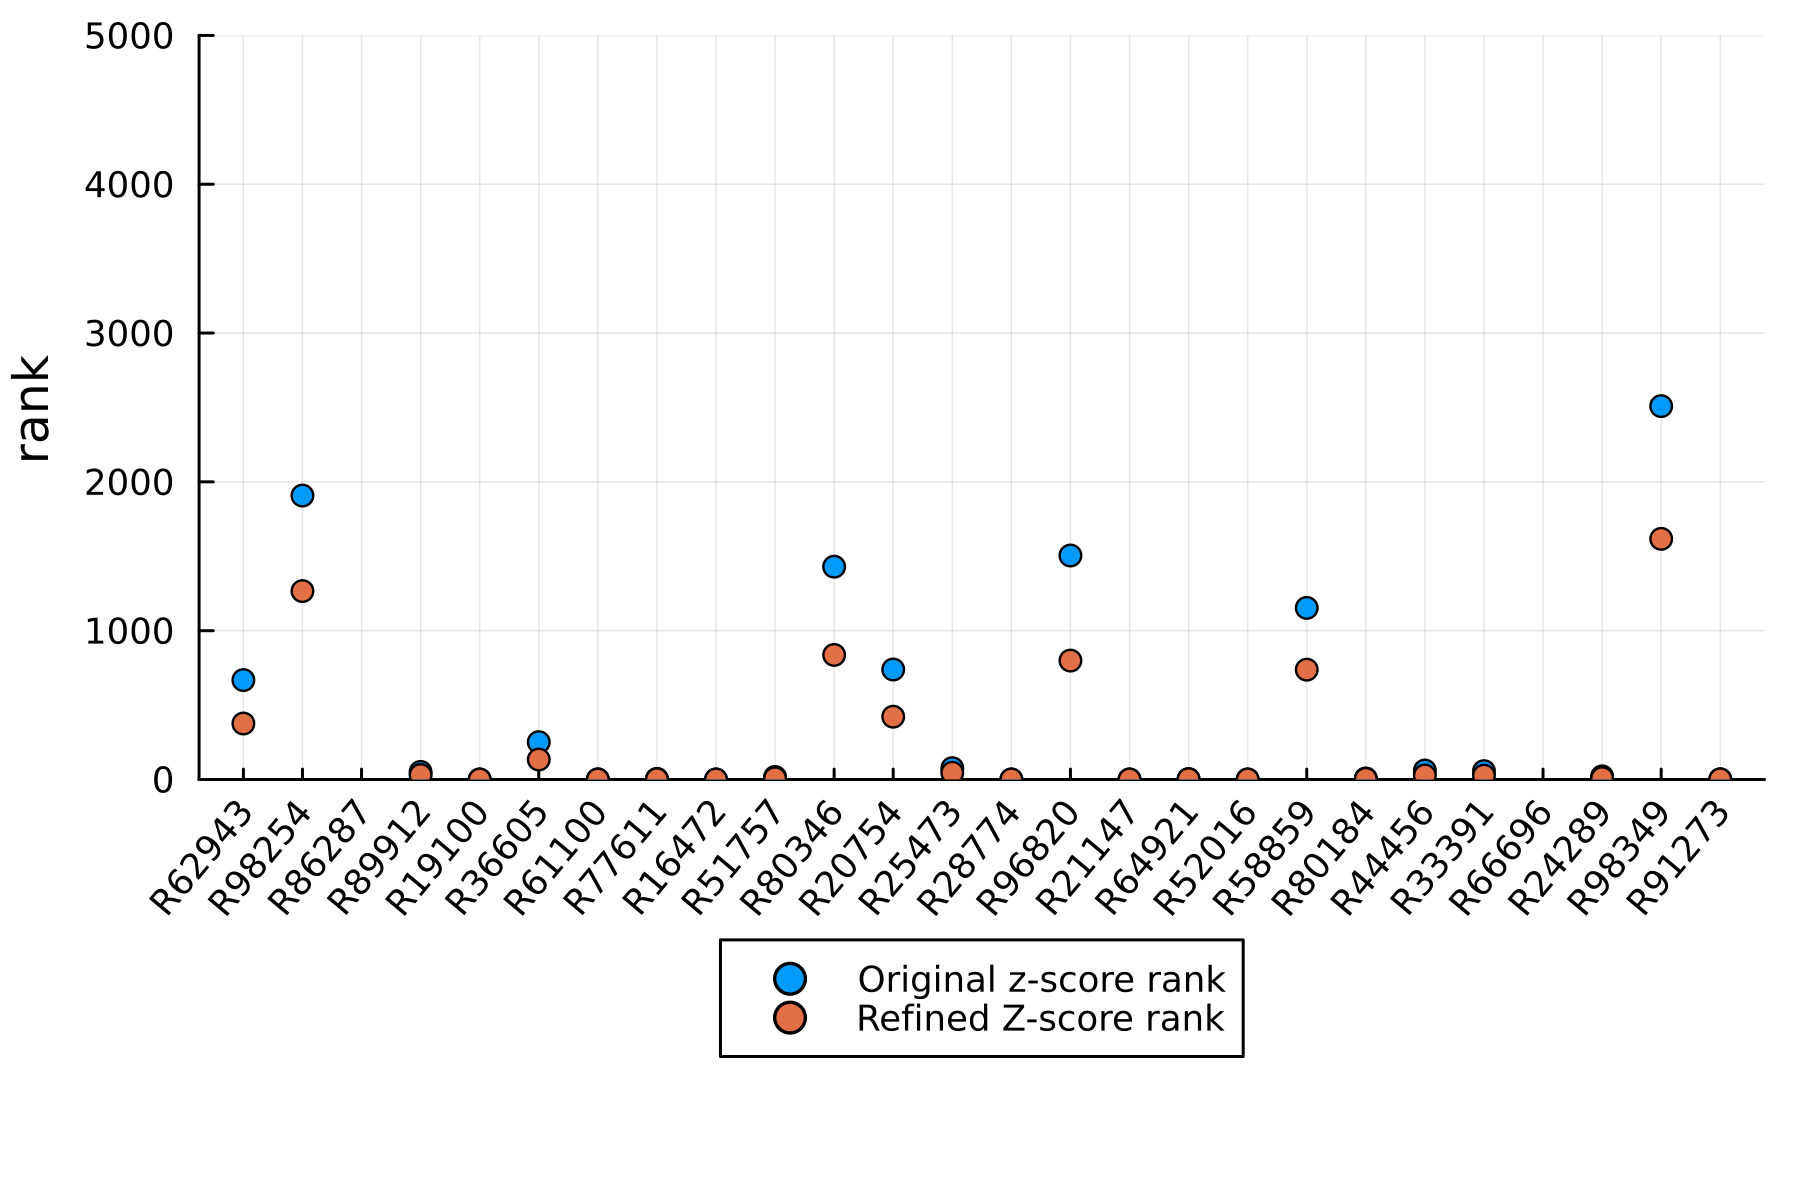

In [13]:
using Plots
gr(fmt=:png)

scatter(
    1:length(patient_name_success), 
    Z_score_rank, 
    ylabel="rank", 
    xticks=(1:length(patient_name_success), patient_name_success),
    xrotation = 50,
    label = "Original z-score rank",
    legend=:outerbottom,
    dpi=300,
    ylim=(0, 5000)
)
scatter!(1:length(patient_name_success), RCD_rank, label="Refined Z-score rank")

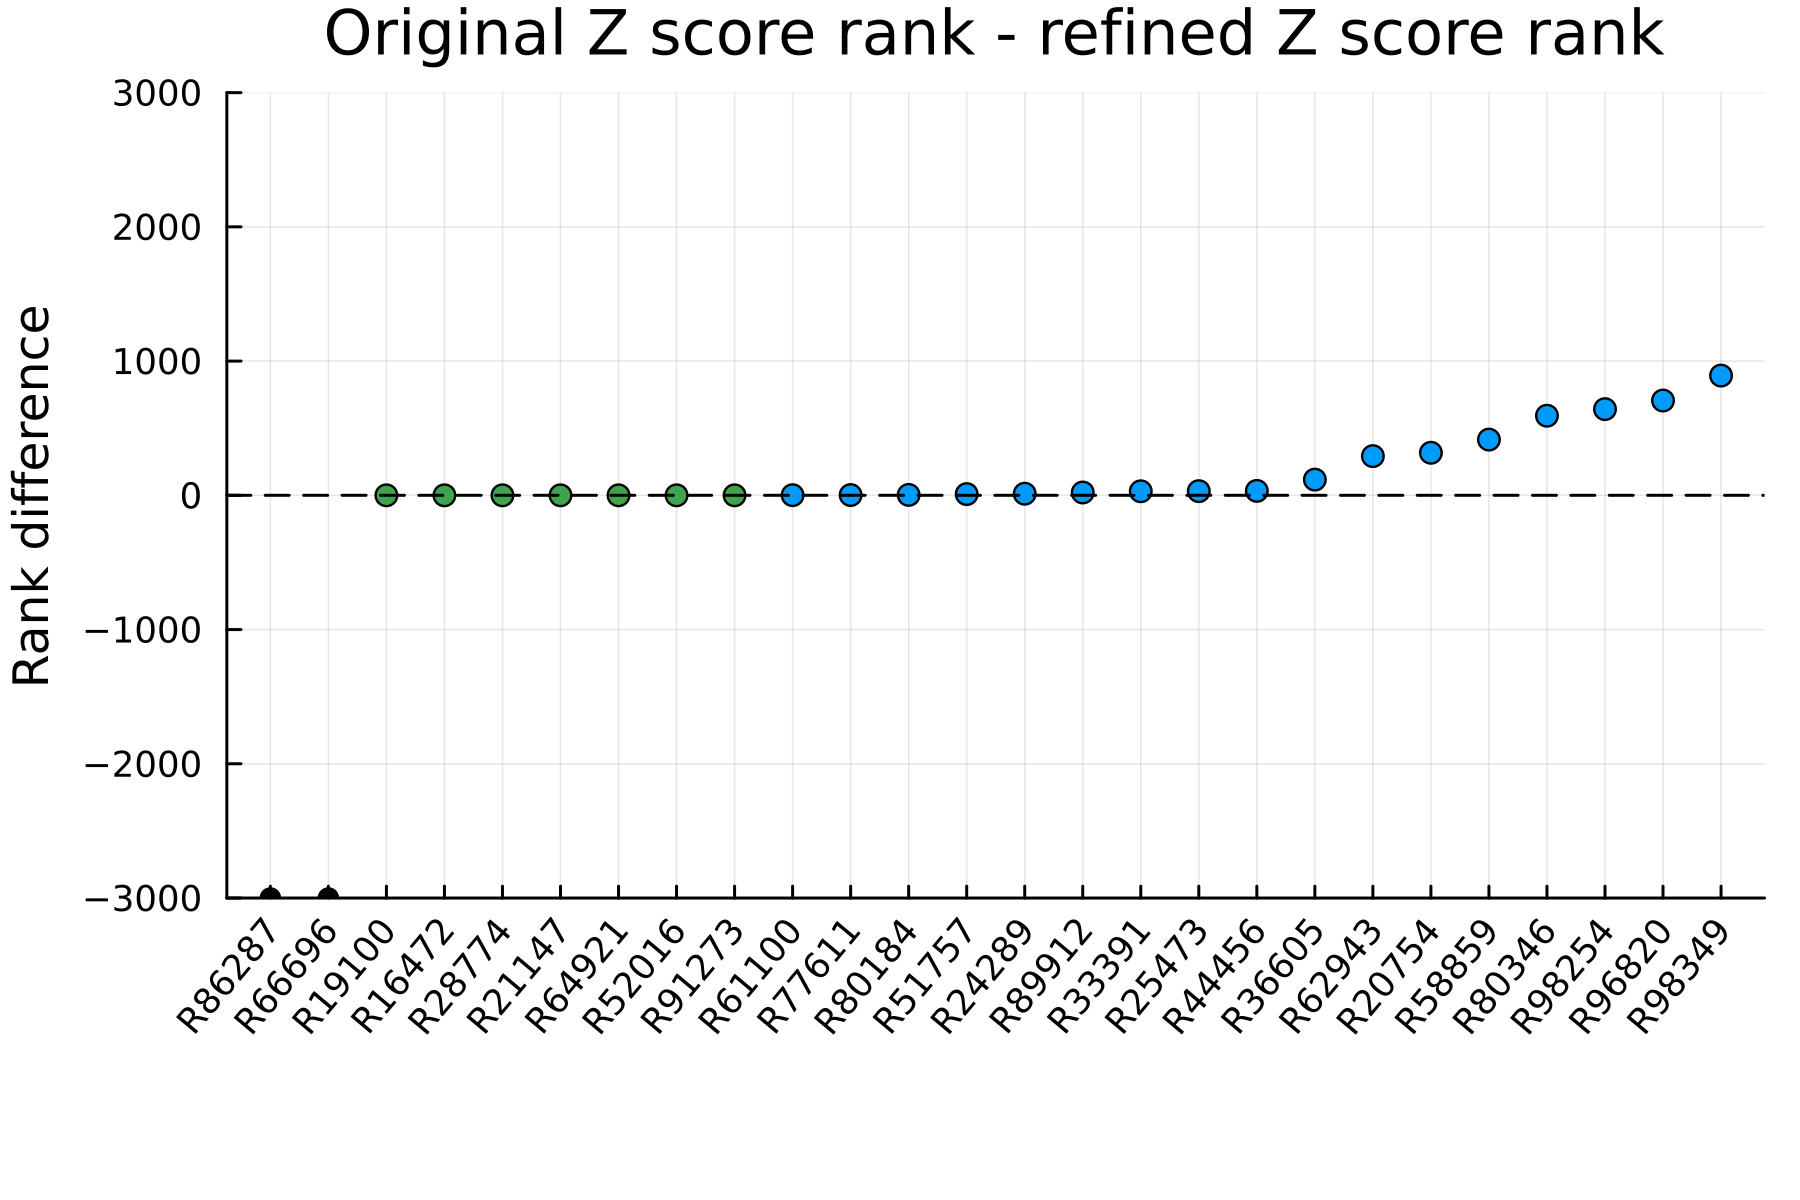

In [14]:
Z_score_diff = Z_score_rank - RCD_rank
palettes = theme_palette(:auto)
my_colors = []
ymax = 3000
ymin = -3000
for i in eachindex(Z_score_diff)
    if isinf(Z_score_diff[i])
        push!(my_colors, :black)
        Z_score_diff[i] = ymin
    elseif Z_score_diff[i] > 0
        push!(my_colors, palettes[1])
    elseif Z_score_diff[i] == 0
        push!(my_colors, palettes[3])
    else
        push!(my_colors, palettes[2])
    end
end

# sort by diff in Z scores
perm = sortperm(Z_score_diff)

# make plot
scatter(
    1:length(patient_name_success), 
    Z_score_diff[perm],
    title="Original Z score rank - refined Z score rank", 
    ylabel="Rank difference",
    xticks=(1:length(patient_name_success), patient_name_success[perm]),
    xrotation = 50,
    ylim=(ymin, ymax),
    label = nothing,
    legend=:outerbottom,
    color=my_colors[perm],
    dpi=300,
)
hline!([0], color=:black, linestyle=:dash, label=nothing)